In [29]:
import pandas as pd

# Loading the datasets
customers_file = "data\Customers.csv" # cpy file path
products_file = "data\Products.csv"   # cpy file path
transactions_file = "data\Transactions.csv" # cpy file path

customers = pd.read_csv(customers_file)
products = pd.read_csv(products_file)
transactions = pd.read_csv(transactions_file)

# Displaying the first few rows of each dataset to understand their structure
customers.head(), products.head(), transactions.head()


(  CustomerID        CustomerName         Region  SignupDate
 0      C0001    Lawrence Carroll  South America  2022-07-10
 1      C0002      Elizabeth Lutz           Asia  2022-02-13
 2      C0003      Michael Rivera  South America  2024-03-07
 3      C0004  Kathleen Rodriguez  South America  2022-10-09
 4      C0005         Laura Weber           Asia  2022-08-15,
   ProductID              ProductName     Category   Price
 0      P001     ActiveWear Biography        Books  169.30
 1      P002    ActiveWear Smartwatch  Electronics  346.30
 2      P003  ComfortLiving Biography        Books   44.12
 3      P004            BookWorld Rug   Home Decor   95.69
 4      P005          TechPro T-Shirt     Clothing  429.31,
   TransactionID CustomerID ProductID      TransactionDate  Quantity  \
 0        T00001      C0199      P067  2024-08-25 12:38:23         1   
 1        T00112      C0146      P067  2024-05-27 22:23:54         1   
 2        T00166      C0127      P067  2024-04-25 07:38:55    

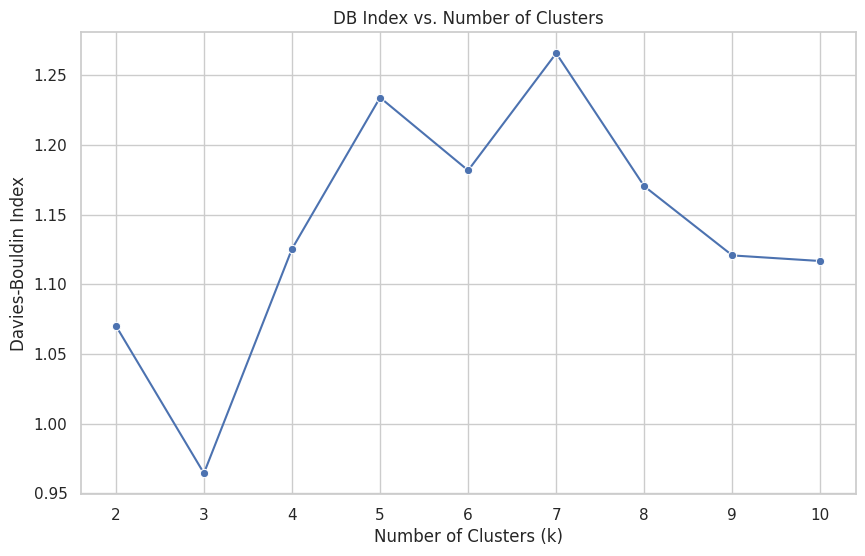

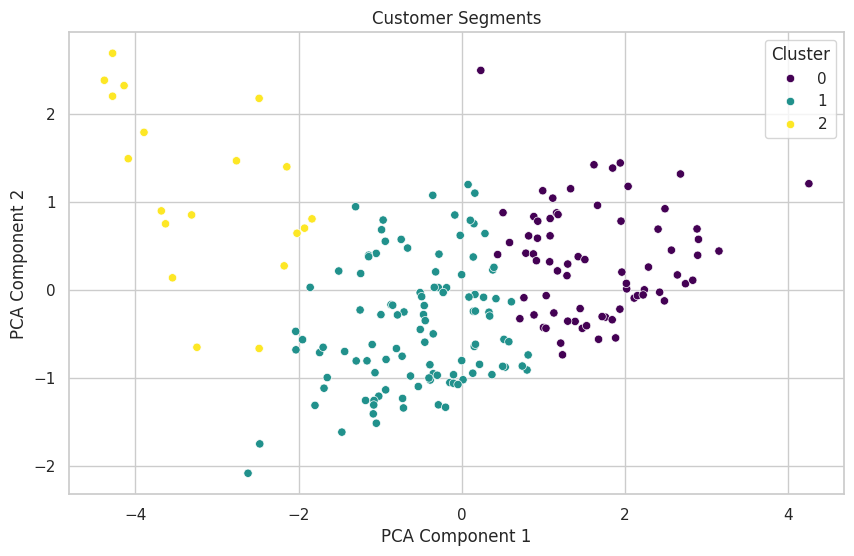

In [27]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# Loading datasets
customers = pd.read_csv("data\Customers.csv")
products = pd.read_csv("data\Products.csv")
transactions = pd.read_csv("data\Transactions.csv")

# Merging datasets
transactions_products = pd.merge(transactions, products, on="ProductID", how="left")
full_data = pd.merge(transactions_products, customers, on="CustomerID", how="left")

# Aggregation of customer features
customer_features = full_data.groupby("CustomerID").agg({
    "TotalValue": "sum",  # Total transaction value
    "TransactionID": "count",  # Transaction frequency
    "Category": "nunique",  # Unique categories
    "TransactionDate": lambda x: (pd.Timestamp("2025-01-01") - pd.to_datetime(x).max()).days  # Recency
}).rename(columns={
    "TotalValue": "TotalSpend",
    "TransactionID": "TransactionFrequency",
    "Category": "UniqueCategories",
    "TransactionDate": "Recency"
}).reset_index()

# Normalizing features
scaler = StandardScaler()
features = customer_features[["TotalSpend", "TransactionFrequency", "UniqueCategories", "Recency"]]
scaled_features = scaler.fit_transform(features)

# Finding optimal clusters (2 to 10)
db_scores = []
k_values = range(2, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled_features)
    db_scores.append(davies_bouldin_score(scaled_features, labels))

optimal_k = k_values[db_scores.index(min(db_scores))]

# Performing clustering with optimal clusters
kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42)
customer_features["Cluster"] = kmeans_optimal.fit_predict(scaled_features)

# Ploting DB Index for visualization
plt.figure(figsize=(10, 6))
sns.lineplot(x=k_values, y=db_scores, marker='o')
plt.title("DB Index vs. Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Davies-Bouldin Index")
plt.savefig("db_index_plot.png")# saving the fig in png formate
plt.show()

# Visualizing clusters in 2D :
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_features[:, 0], y=pca_features[:, 1], hue=customer_features["Cluster"], palette="viridis")
plt.title("Customer Segments")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.savefig("cluster_visualization.png")
plt.show()
# Saving results in csv file
customer_features.to_csv("Clustering_Results.csv", index=False)




In [28]:
#Final details
print(f"Optimal number of clusters: {optimal_k}")
print(f"Minimum DB Index: {min(db_scores)}")

Optimal number of clusters: 3
Minimum DB Index: 0.9644448290687739
